Flux diffusion for postprocessing $L=4\pi r^2 F_r$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import athena_read as ar
import OrbitAnalysisUtils as ou
import Constants 

from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm.auto import tqdm

#from skimage import measure
import scipy
from scipy.interpolate import RegularGridInterpolator
from scipy.special import expit
from athena_read import athdf

c=Constants.Constants()

%matplotlib inline

radius = 7.e12
t_dyn_giant = (radius**3/c.G/c.msun)**0.5
base_dir = '../../data/planetary_engulfment_test39/'
gamma=1.66667
orb = ou.read_trackfile(base_dir+"pm_trackfile.dat")

Constants defined...
reading orbit file for binary simulation...


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import athena_read as ar
import OrbitAnalysisUtils as ou
import Constants 

from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm.auto import tqdm
#from skimage import measure
import scipy
from scipy.interpolate import RegularGridInterpolator
from scipy.special import expit
from athena_read import athdf

c=Constants.Constants()

from scipy import optimize

# EOS(radiation pressure and ideal gas pressure)
# P/rho = 4*c.sigmaSB*x**4/3/c.c/rho+c.kB*x/1.25*2/c.mp

def temp_rad_gas(rho,press):
    f = lambda x, rho,epsilon: 4*c.sigmaSB*x**4/3/c.c/rho+c.kB*x/1.25*2/c.mp-epsilon
    fder = lambda x, rho,epsilon: 16*c.sigmaSB*x**3/3/c.c/rho+c.kB/1.25*2/c.mp
    
    x = 1e3*np.ones_like(rho)
    epsilon = press/rho
    
    return optimize.newton(f, x, fprime=fder, args=(rho,epsilon, ), maxiter=200)

#  interp functions
def get_interp_function(d,var,rescale_factor=1,method = 'nearest'): #'
    """
    MM: Use RegularGridInterpolator to pass data to interpolating function for a given variable
    Parameters
    -----------
    d : dict
       athena data dict from read_data
    var: str
       name of variable to be interpolated
       
    Returns
    --------
    var_interp: an interpolating function that can be called with a tuple (phi,theta,r)
    """
    dph = np.gradient(d['x3v'])[0]
    dtheta = np.gradient(d['x2v'])[0]
    two_pi = ( (d['x3v'][-1]-d['x3v'][0]+dph) /(2*np.pi) > 0.99 ) # boolean to determine if spans 2pi in phi
    x1v = d['x1v']*rescale_factor
    var_shape = d[var].shape
    
    if two_pi:
        x3v = np.append(d['x3v'][0]-dph,d['x3v'])
        x3v = np.append(x3v,x3v[-1]+dph)
        var_data = np.append([d[var][-1]],d[var],axis=0)
        var_data = np.append(var_data,[var_data[0]],axis=0)
        var_shape = var_data.shape
    else:
        x3v = d['x3v']
        var_data = d[var]
        
    # extend in theta
    x2v = np.append(d['x2v'][0]-dtheta,d['x2v'])
    x2v = np.append(x2v,x2v[-1]+dtheta)
    var_data = np.append(var_data[:,0,:].reshape(var_shape[0],1,var_shape[2]),var_data,axis=1)
    var_data = np.append(var_data,var_data[:,-1,:].reshape(var_shape[0],1,var_shape[2]),axis=1)
        
    var_interp = RegularGridInterpolator((x3v,x2v,x1v),var_data,bounds_error=False,method=method)
    return var_interp

def cart_to_polar(x,y,z):
    """cartesian->polar conversion (matches 0<phi<2pi convention of Athena++)
    Parameters
    x, y, z
    Returns
    r, th, phi
    """
    r = np.sqrt(x**2 + y**2 +z**2)
    th = np.arccos(z/r)
    phi = np.arctan2(y,x)
    phi = np.where(phi>=0,phi,phi+2*np.pi)
    return np.stack((r, th, phi), axis=2)

def mesh_interpolate_at_xyzpoints(d,var,points):
    """
    MM: convience function to interpolate a variable to mesh points
    Parameters
    -----------
    d: athena++ data dict
    var: str variable name in, e.g. "rho"
    points: array of cartesian positions (eg vertices or centroids) (n,n,3) floats (x,y,z)
    """
    var_interp = get_interp_function(d,var)
    rp,thp,php = cart_to_polar(points[:,:,0],points[:,:,1],points[:,:,2])
    return var_interp( (php,thp,rp) )

### integrate along radius from every solid angle
mylevel = None

# considering Hydrogen and ff opacity
def ff_opacity(rho, temp, wavelength):
    # in cgs unit
    opacity = 4.97*rho**2/temp**0.5*wavelength**3*1000
    return opacity

def Rosseland_mean_opacity(rho,temp):
    # in cgs unit
    opacity = 8e22*temp**(-7/2)*rho**2
    return opacity

def opac(rho,temp,X,Z):
    # in cgs units
    # molecules
    kappa_m = 0.1*Z
    
    # negative hydrogen ion
    kappa_nH = 1.1e-25*Z**0.5*rho**0.5*temp**7.7
    
    # electron scattering
    kappa_e = 0.2*(1+X)/(1+2.7e11*rho/temp**2)/(1+(temp/4.5e8)**0.86)
    
    # Kramers formula
    kappa_K = 4e25*(1+X)*(Z+0.001)*rho/temp**3.5
    
    opacity = (kappa_m+1.0/(1.0/kappa_nH+1/(kappa_e+kappa_K)))
    
    return opacity



def Blackbody(wavelength,temp):
    """
    Planck blackbody emission, in cgs units, wavelength in nm
    """
    a = 2*c.h*c.c**2
    b = c.h*c.c/(wavelength*1e-7)/c.kB/temp
    return a/(wavelength*1e-7)**5/(np.exp(b)-1.0)



     
    
def optical_depth_radial(data, wavelength, rescale_factor=1, dx = -1,plot = True):
    """Marching along the radial direction from outter boundary to find photosphere radii
    
    Parameters:
    -------
    data: athena++ data dict
    wavelength: observer wavelength in nm
    Returns: 
    (n_phi,n_theta) array with photosphere radii('x1v') of each solid angle interval
    (n_phi,n_theta) array with photosphere radii id of each solid angle interval 
    """
    
    ## initializition
    n_theta = len(data['x2v'])
    n_phi   = len(data['x3v'])
    op_dep = np.zeros((n_phi,n_theta))
    pho_radii = np.ones((n_phi,n_theta))*data['x1v'][-1]
    pho_id    = np.ones((n_phi,n_theta))*int(len(data['x1v'])-1)
    op_dep_id = int(len(data['x1v'])-1)
    
    # use success matrix to determine if the line of sight is on the star,-1 for no, 1 for yes, 0 for first success
    success= -1*np.ones((n_phi,n_theta)) 
    
    ## get data
    # correction for r0
    r0_thresh =0.9
    rho_star = np.where(data['r0']>r0_thresh,data['rho']*data['r0'],0)
     
    #rho_star = data['rho']*data['r0']
    #temp = temp_rad_gas(data['rho'],data['press'])
    temp = data['press']/data['rho']*c.mp*1.25/2/c.kB

    while np.any(success==-1):
        
        rho_box  = rho_star[:,:,op_dep_id]
        temp_box = temp[:,:,op_dep_id]
            
        dx = data['x1f'][op_dep_id+1]-data['x1f'][op_dep_id]
            
        op_dep_new = op_dep + rho_box*opac(rho_box,temp_box,0.7,0.02)*dx
        op_dep_new = np.nan_to_num(op_dep_new, nan=0, posinf=1000, neginf=-1000)

        op_dep = np.where(op_dep>=1,op_dep,op_dep_new)
        success = np.where(op_dep>=1,success+1,success)
        
        # if first success, restore the success coordinates
        pho_radii = np.where(success==0,data['x1v'][op_dep_id],pho_radii)
        pho_id = np.where(success==0,op_dep_id,pho_id)
        
        """
        if np.any(success==0):
            pho_radii = np.where(success==0,data['x1v'][op_dep_id-1],pho_radii)
            pho_id = np.where(success==0,op_dep_id-1,pho_id)
            
        """
        
        #marching
        op_dep_id -= 1
        success = np.where(success>=1,1,success)
        
            
    # plot
    if plot: 
        plt.imshow(pho_radii.T/c.rsun)
        plt.colorbar()  # Add a color bar to show the scale
        plt.title('Photosphere radius Plot')
        plt.xlabel('$phi$')
        plt.ylabel('$theta$')
        plt.show()
        
    return pho_radii,pho_id




Constants defined...


In [3]:
from scipy import optimize

# EOS(radiation pressure and ideal gas pressure)
# P/rho = 4*c.sigmaSB*x**4/3/c.c/rho+c.kB*x/1.25*2/c.mp

def temp_rad_gas(rho,press):
    f = lambda x, rho,epsilon: 4*c.sigmaSB*x**4/3/c.c/rho+c.kB*x/1.25*2/c.mp-epsilon
    fder = lambda x, rho,epsilon: 16*c.sigmaSB*x**3/3/c.c/rho+c.kB/1.25*2/c.mp
    
    x = 1e3*np.ones_like(rho)
    epsilon = press/rho
    
    return optimize.newton(f, x, fprime=fder, args=(rho,epsilon, ), maxiter=200)

In [4]:
def radialFlux(data):
    temp_1d=np.array((np.array(data['press'],dtype=np.float64)/np.array(data['rho'],dtype=np.float64)*c.mp*1.25/2/c.kB)[100,48,:],dtype=np.float64)
    #temp_1d=temp_rad_gas(data['rho'][100,48,:],data['press'][100,48,:])
    r_1d=data['x1v']
    a=4*c.sigmaSB/c.c
    slopeT=((temp_1d)[1:]-(temp_1d)[:-1])/(r_1d[1:]-r_1d[:-1])
    deltaU=np.array(((temp_1d**4)[1:]-(temp_1d**4)[:-1]),dtype=np.float64)
    slopeU=np.array(((temp_1d**4)[1:]-(temp_1d**4)[:-1])/(r_1d[1:]-r_1d[:-1]),dtype=np.float64)
    
    # F=-c/(3\rho\kappa) slopeU
    rho_1d=data['rho'][100,48,:]
    r0_1d=data['r0'][100,48,:]
    #

    data_mesa=np.loadtxt('semiData/data.txt')
    kappa_mesa=data_mesa[:,3]
    kappa_1d_mesa=10**kappa_mesa
    kappa_1d=opac(rho_1d,temp_1d,0.7,0.02)

    flux_1d=[-4*c.sigmaSB/3/rho_1d[i]/kappa_1d[i]*slopeU[i] for i in range(len(slopeU))]
    
    flux_1d_2=[-16/3*c.sigmaSB*temp_1d[i]**3/rho_1d[i]/kappa_1d[i]*slopeT[i] for i in range(len(slopeT))]
    
    #limiter
    R=np.abs(4*slopeT/rho_1d[:-1]/kappa_1d[:-1]/temp_1d[:-1])
    lambdaLim=(2+R)/(6+3*R+R**2)
    #flux_1d_lim=[-16*lambdaLim[i]*c.sigmaSB*temp_1d[i]**3/rho_1d[i]/kappa_1d[i]*slopeT[i] for i in range(len(slopeT))]
    flux_1d_lim=[-4*lambdaLim[i]*c.sigmaSB/rho_1d[i]/kappa_1d[i]*slopeU[i] for i in range(len(slopeU))]
    #flux_1d_lim=np.where(np.array(flux_1d_lim)<0,0,flux_1d_lim)
    
    R=np.abs(4*slopeT/rho_1d[:-1]/kappa_1d_mesa[:-1]/temp_1d[:-1])
    lambdaLim=(2+R)/(6+3*R+R**2)
    #flux_1d_lim=[-16*lambdaLim[i]*c.sigmaSB*temp_1d[i]**3/rho_1d[i]/kappa_1d[i]*slopeT[i] for i in range(len(slopeT))]
    flux_1d_lim_mesa=[-4*lambdaLim[i]*c.sigmaSB/rho_1d[i]/kappa_1d_mesa[i]*slopeU[i] for i in range(len(slopeU))]
    return np.array(flux_1d_lim),np.array(flux_1d_lim_mesa)


def isStable(data):
    temp_1d=(data['press']/data['rho']*c.mp*1.25/2/c.kB)[100,48,:]
    press_1d=data['press'][100,48,:]
    res=(np.log(temp_1d)[1:]-np.log(temp_1d)[:-1])/(np.log(press_1d)[1:]-np.log(press_1d)[:-1])
    
    return res
    
    

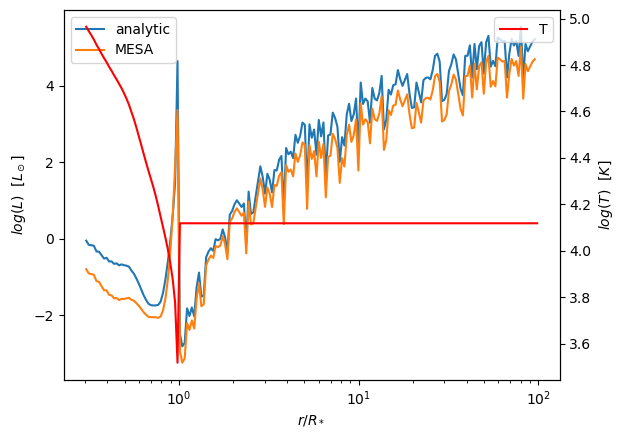

In [52]:
base_dir = '../../data/planetary_engulfment_test39/'
data = athdf(base_dir+'/PEGM.out1.00000.athdf')

fig,ax = plt.subplots()
ax_r=ax.twinx()
ax.plot(data['x1v'][:-1]/radius,np.log10(np.abs(4*np.pi*data['x1v'][:-1]**2*radialFlux(data)[0])/c.lumsun),label='analytic')
ax.plot(data['x1v'][:-1]/radius,np.log10(np.abs(4*np.pi*data['x1v'][:-1]**2*radialFlux(data)[1])/c.lumsun),label='MESA')#
#plt.plot(data['x1v'][:-1]/radius,np.log10(np.abs(4*np.pi*data['x1v'][:-1]**2*radialFlux(data)[1])/c.lumsun))
#plt.plot(data['x1v'][:-1]/radius,np.log10((radialFlux(data)))) #

ax_r.plot(data['x1v']/radius,np.log10(data['press']/data['rho']*c.mp*1.25/2/c.kB)[100,48,:],'r',label='T')
#plt.plot(data['x1v']/radius,data['r0'][100,48,:])
#plt.xlim(0.3,1)
ax.set_xscale('log')
ax.set_xlabel(r'$r/R_*$')
ax.set_ylabel(r'$log(L)\ \ [L_\odot]$')
ax_r.set_ylabel(r'$log(T)\ \ [K]$')
ax.legend()
ax_r.legend()
#plt.yscale('log')
#plt.ylim(36,42)

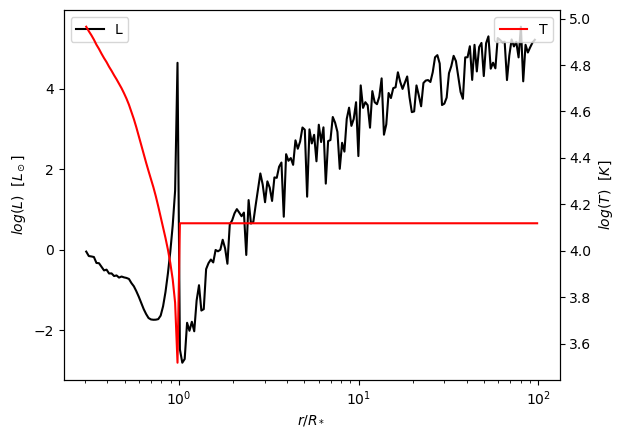

In [47]:
base_dir = '../../data/planetary_engulfment_test39/'
data = athdf(base_dir+'/PEGM.out1.00000.athdf')

fig,ax = plt.subplots()
ax_r=ax.twinx()
ax.plot(data['x1v'][:-1]/radius,np.log10(np.abs(4*np.pi*data['x1v'][:-1]**2*radialFlux(data))/c.lumsun),'k',label='L') #
#plt.plot(data['x1v'][:-1]/radius,np.log10(np.abs(4*np.pi*data['x1v'][:-1]**2*radialFlux(data)[1])/c.lumsun))
#plt.plot(data['x1v'][:-1]/radius,np.log10((radialFlux(data)))) #

ax_r.plot(data['x1v']/radius,np.log10(data['press']/data['rho']*c.mp*1.25/2/c.kB)[100,48,:],'r',label='T')
#plt.plot(data['x1v']/radius,data['r0'][100,48,:])
#plt.xlim(0.3,1)
ax.set_xscale('log')
ax.set_xlabel(r'$r/R_*$')
ax.set_ylabel(r'$log(L)\ \ [L_\odot]$')
ax_r.set_ylabel(r'$log(T)\ \ [K]$')
ax.legend()
ax_r.legend()
#plt.yscale('log')
#plt.ylim(36,42)

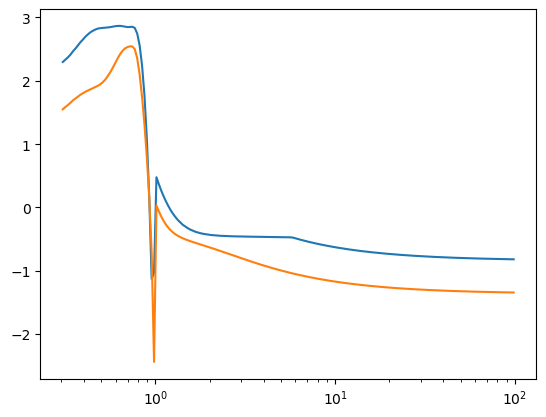

In [43]:
fig,ax = plt.subplots()
data_mesa=np.loadtxt('semiData/data.txt')
kappa_mesa=data_mesa[:,3]
ax.plot(data['x1v']/radius,kappa_mesa,label='MESA') 

ax.plot(data['x1v']/radius,np.log10(opac(data['rho'][100,48,:],(data['press']/data['rho']*c.mp*1.25/2/c.kB)[100,48,:],0.7,0.02)),label='analytic') 
ax.set_xscale('log')

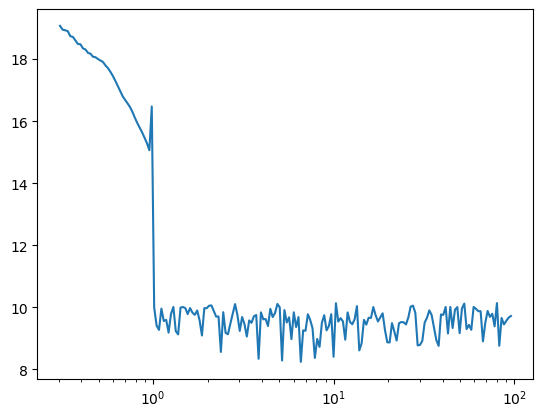

In [68]:
base_dir = '../../data/planetary_engulfment_test39/'
data = athdf(base_dir+'/PEGM.out1.00000.athdf')


#plt.plot(data['x1v'][:-1]/radius,np.log10(np.abs(4*np.pi*data['x1v'][:-1]**2*radialFlux(data))/c.lumsun)) #
#plt.plot(data['x1v'][:-1]/radius,np.log10(np.abs(4*np.pi*data['x1v'][:-1]**2*radialFlux(data)[1])/c.lumsun))
plt.plot(data['x1v'][:-1]/radius,np.log10(np.abs(radialFlux(data)))) #
#
#plt.plot(data['x1v']/radius,data['r0'][100,48,:])
#plt.xlim(0.3,1)
plt.xscale('log')
#plt.yscale('log')

#plt.ylim(36,42)

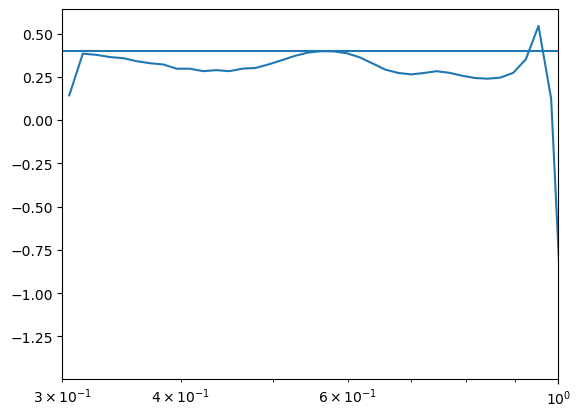

In [15]:
plt.plot(data['x1v'][:-1]/radius,isStable(data)) 
plt.xlim(0.3,1)
plt.axhline(y=0.4)
plt.xscale('log')

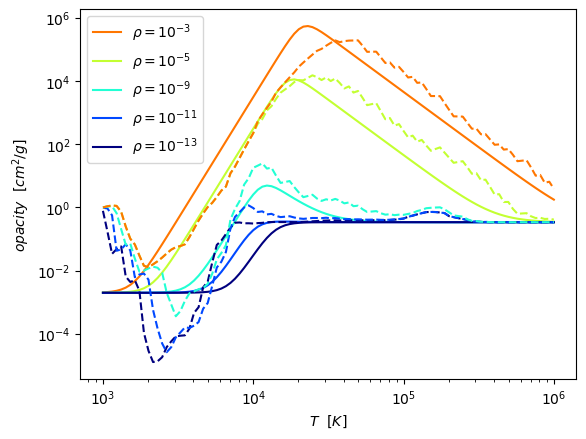

In [7]:
temp=np.logspace(3,6,100)
opacity13=opac(1e-13*np.ones_like(temp),temp,0.7,0.02)
opacity11=opac(1e-11*np.ones_like(temp),temp,0.7,0.02)
opacity9=opac(1e-9*np.ones_like(temp),temp,0.7,0.02)
opacity5=opac(1e-5*np.ones_like(temp),temp,0.7,0.02)
opacity3=opac(1e-3*np.ones_like(temp),temp,0.7,0.02)

plt.plot(temp,opacity3,color=plasma_hex_array[200],label=r'$\rho=10^{-3}$')
plt.plot(temp,opacity5,color=plasma_hex_array[150],label=r'$\rho=10^{-5}$')
plt.plot(temp,opacity9,color=plasma_hex_array[100],label=r'$\rho=10^{-9}$')
plt.plot(temp,opacity11,color=plasma_hex_array[50],label=r'$\rho=10^{-11}$')
plt.plot(temp,opacity13,color=plasma_hex_array[0],label=r'$\rho=10^{-13}$')

script_dir = os.getcwd()
exe_path = os.path.join(script_dir, "opacMesa.exe")

opacity_mesa = run_exe_batch(exe_path, np.log10(temp),getLogR(np.log10(temp),np.log10(1e-13*np.ones_like(temp))))
plt.plot(temp,10**np.array(opacity_mesa),'--',color=plasma_hex_array[0])
opacity_mesa = run_exe_batch(exe_path, np.log10(temp),getLogR(np.log10(temp),np.log10(1e-11*np.ones_like(temp))))
plt.plot(temp,10**np.array(opacity_mesa),'--',color=plasma_hex_array[50])
opacity_mesa = run_exe_batch(exe_path, np.log10(temp),getLogR(np.log10(temp),np.log10(1e-9*np.ones_like(temp))))
plt.plot(temp,10**np.array(opacity_mesa),'--',color=plasma_hex_array[100])
opacity_mesa = run_exe_batch(exe_path, np.log10(temp),getLogR(np.log10(temp),np.log10(1e-5*np.ones_like(temp))))
plt.plot(temp,10**np.array(opacity_mesa),'--',color=plasma_hex_array[150])
opacity_mesa = run_exe_batch(exe_path, np.log10(temp),getLogR(np.log10(temp),np.log10(1e-3*np.ones_like(temp))))
plt.plot(temp,10**np.array(opacity_mesa),'--',color=plasma_hex_array[200])

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$Opacity\ \ [cm^2/g]$')
plt.xlabel(r'$T\ \ [K]$')
plt.legend()

time for reading file= 2.456364631652832
time for getting table= 187.58286309242249
time for analytical calculation= 0.16938042640686035


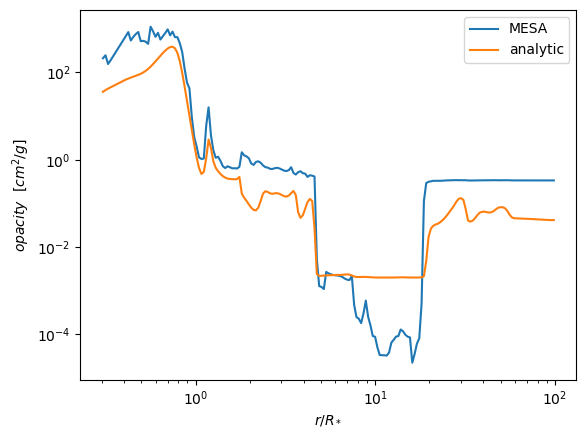

In [8]:
import time
time1=time.time()
base_dir = '../../data/planetary_engulfment_test39/'
data = athdf(base_dir+'/PEGM.out1.00400.athdf')
temp=data['press']/data['rho']*c.mp*1.25/2/c.kB
dens=data['rho']
fig,ax = plt.subplots()
# ax_r=ax.twinx()

script_dir = os.getcwd()
exe_path = os.path.join(script_dir, "opacMesa.exe")
print('time for reading file=',time.time()-time1)
time1=time.time()
output = run_exe_batch(exe_path, np.log10(temp),getLogR(np.log10(temp),np.log10(dens)))
print('time for getting table=',time.time()-time1)
time1=time.time()
ax.plot(data['x1v']/radius,10**np.array(output)[0,48,:],label='MESA')
ax.plot(data['x1v']/radius,opac(dens,temp,0.7,0.02)[0,48,:],label='analytic')


ax.set_xscale('log')
ax.set_xlabel(r'$r/R_*$')
ax.set_yscale('log')
ax.set_ylabel(r'$opacity\ \ [cm^2/g]$')
ax.legend()
print('time for analytical calculation=',time.time()-time1)


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def get_plasma_colormap_strings(num_colors=256):
    """
    Returns the plasma colormap as an array of hex color strings
    
    Args:
        num_colors: Number of colors to extract from the colormap
        
    Returns:
        List of hex color strings (e.g., '#ff0033')
    """
    plasma = plt.get_cmap('jet')
    colors = plasma(np.linspace(0, 1, num_colors))
    return [f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}' 
            for r, g, b, _ in colors]

# Generate array
plasma_hex_array = get_plasma_colormap_strings()


In [18]:
athena_data=np.column_stack(((data['press']/data['rho']*c.mp*1.25/2/c.kB)[100,48,:],data['rho'][100,48,:]))
np.savetxt('semiData/athena_data.txt',athena_data)

In [4]:
import os
import sys
import subprocess
from typing import List

def run_exe_batch(exe_path, logT_array: np.ndarray, logR_array: np.ndarray) -> np.ndarray:
    """
    Run the .exe with numpy arrays of logT and logR values via stdin and return outputs.
    NOTE: Opacity tables must exist in the current directory. Currently only support 
    "gs98_z0.02_x0.7.data" and "lowT_fa05_gs98_z0.02_x0.7.data".
    
    Args:
        logT_array: ND array of logT values
        logR_array: ND array of logR values (same shape as logT_array)
    
    Returns:
        ND array of output values matching input shape
    """
    # Validation checks
    if logT_array.shape != logR_array.shape:
        raise ValueError("Input arrays must have identical dimensions")
    if logT_array.size == 0:
        raise ValueError("Input arrays cannot be empty")

    # Path resolution
    exe_full_path = os.path.join(
        os.path.dirname(os.path.abspath(sys.argv[0])) if hasattr(sys, 'argv') else os.getcwd(),
        exe_path
    )
    if not os.path.exists(exe_full_path):
        raise FileNotFoundError(f"Executable not found at {exe_full_path}")

    # Array preprocessing
    original_shape = logT_array.shape
    logT_flat = logT_array.ravel()
    logR_flat = logR_array.ravel()

    # Optimized input generation
    header = f"{logT_array.size}\n"
    body = "\n".join(f"{t:.6f} {r:.6f}" for t, r in zip(logT_flat, logR_flat))
    input_data = header + body + "\n"

    # Process execution with buffering
    with subprocess.Popen(
        [exe_full_path],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        bufsize=2**20  # 1MB buffer for large datasets
    ) as proc:
        stdout, stderr = proc.communicate(input=input_data)
    
    if proc.returncode != 0:
        raise RuntimeError(f"Execution failed: {stderr.strip()}")

    # Memory-efficient output parsing
    try:
        outputs = np.fromstring(stdout, sep='\n', dtype=np.float32)
    except ValueError as e:
        raise ValueError(f"Output parsing failed: {e}\nRaw output: {stdout[:200]}...")

    if outputs.size != logT_array.size:
        raise RuntimeError(f"Expected {logT_array.size} outputs, got {outputs.size}")
    
    return outputs.reshape(original_shape)

def getLogR(logT,logRho):
    return logRho-3*logT+18

In [32]:
import time
time1=time.time()
script_dir = os.getcwd()
exe_path = os.path.join(script_dir, "opacMesa.exe")
n=100
output = run_exe_batch(exe_path, np.array([[-1]*n]*n),np.array([[-1]*n]*n))
print(output[0],output[1])
print(time.time()-time1)

[-0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112
 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112
 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112
 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112
 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112
 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112
 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112
 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112
 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112
 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112] [-0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112
 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112
 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112
 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112 -0.112
 -0.1